In [8]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
from tqdm import tqdm
from scipy.signal import correlate2d
import cv2
from scipy import ndimage, datasets

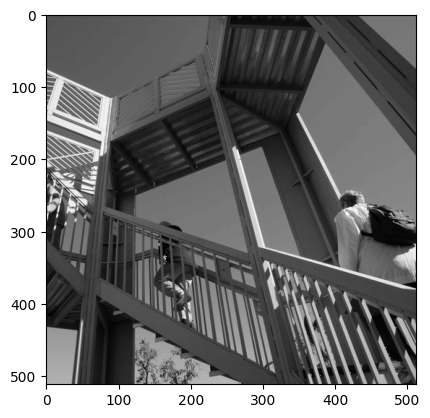

In [387]:
PATCH_SIZE = 7
HALF_SIZE = PATCH_SIZE // 2

PATCH_REGION = lambda i, j : (slice(i - HALF_SIZE, i + HALF_SIZE + 1), \
                              slice(j - HALF_SIZE, j + HALF_SIZE + 1))

SOBEL_X = np.array([
    [-1, 0, 1],
    [-2, 0, 2],
    [-1, 0, 1],
])

SOBEL_Y = np.array([
    [1, 2, 1],
    [0, 0, 0],
    [-1, -2, -1],
])

def grad(img_pt):
    assert img_pt.shape == SOBEL_X.shape

    yh, xh = 1, 1
    grad_x = np.sum(img_pt * SOBEL_X)
    grad_y = np.sum(img_pt * SOBEL_Y)

    gradient = np.array([grad_x, grad_y])
    norm = (np.linalg.norm(gradient))
    
    if norm > 0:
        unit_grad = gradient / norm
    else:
        unit_grad = gradient

    return unit_grad, norm

ascent = datasets.ascent().astype('int32')
plt.imshow(ascent, cmap='gray')

In [388]:
class MaskWithBoundary:
    def __init__(self, mask):
        self.array = mask
        self.init_boundary_pixels()

    def __getitem__(self, idx):
        return self.array[idx]

    def init_boundary_pixels(self):
        height, width = self.array.shape
        self.boundary_pixels = set()

        for i in range(height):
            for j in range(width):
                if self.array[i, j]: continue

                if i == 0 or i == height - 1 or j == 0 or j == width - 1:
                    self.boundary_pixels.add((i, j))

                elif self.array[i - 1, j] or self.array[i + 1, j] or self.array[i, j - 1] or self.array[i, j + 1]:
                    self.boundary_pixels.add((i, j))
        
    def update_boundary_pixels(self, i, j):
        # iterate through edges of patch centered at i, j
        for k in range(-HALF_SIZE, HALF_SIZE + 1):
            if not self.array[i + k, j - HALF_SIZE - 1]:
                self.boundary_pixels.add((i + k, j - HALF_SIZE - 1))
            if not self.array[i + k, j + HALF_SIZE + 1]:
                self.boundary_pixels.add((i + k, j + HALF_SIZE + 1))
            if not self.array[i - HALF_SIZE - 1, j + k]:
                self.boundary_pixels.add((i - HALF_SIZE - 1, j + k))
            if not self.array[i + HALF_SIZE + 1, j + k]:
                self.boundary_pixels.add((i + HALF_SIZE + 1, j + k))

    def fill_patch(self, i, j):
        patch_region = PATCH_REGION(i, j)
        idxs = [(i + y, j + x) for x in range(-HALF_SIZE, HALF_SIZE + 1) for y in range(-HALF_SIZE, HALF_SIZE + 1)]
        self.boundary_pixels -= set(idxs)
        
        self.array[patch_region] = True
        self.update_boundary_pixels(i, j)

    def empty(self):
        return len(self.boundary_pixels) == 0
    
    def render_boundary(self):
        mask_with_boundary = 255 * self.array.copy().astype(np.uint32)

        for (i, j) in self.boundary_pixels:
            mask_with_boundary[i, j] = 128

        plt.imshow(mask_with_boundary, cmap='grey')
        plt.show()

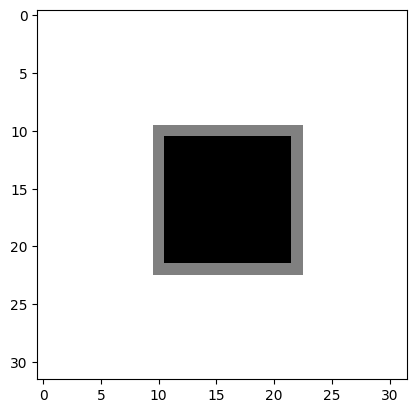

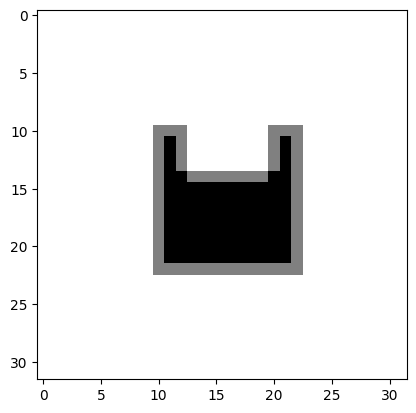

array([-1.,  0.])

In [389]:
mask = np.ones((32, 32), dtype=bool)
mask[10:23, 10:23] = False

mask_with_boundary = MaskWithBoundary(mask)
mask_with_boundary.render_boundary()

mask_with_boundary.fill_patch(10, 16)

# mask_with_boundary.array[21, 10] = 200
mask_with_boundary.render_boundary()

xh, yh = 1, 1
img_pt = mask_with_boundary.array[21 - yh:21 + yh + 1, 10 - xh:10 + xh + 1]
gradient, norm = grad(img_pt)

gradient

-0.894427190999916 -0.447213595499958
0.447213595499958 -0.894427190999916


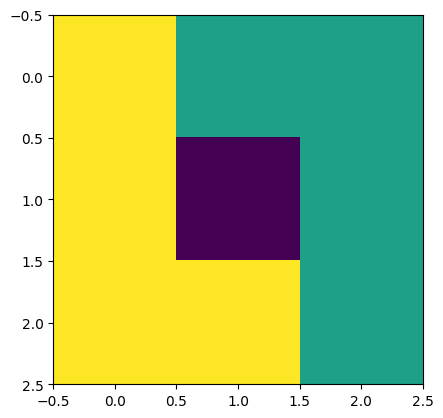

In [390]:
test_img = 255 * np.ones((64, 64), dtype=int)
for i in range(test_img.shape[0]):
    for j in range(test_img.shape[1]):
        if i - 2*j <= -10:
            test_img[i, j] = 200
        # if ((i-32) ** 2 + (j -32) ** 2) < 12 ** 2:
        #     test_img[i, j] = 0

# test_img[41:, :] = 0

r, c = 40, 25
test_img[r, c] = 128

plt.imshow(test_img, cmap='gray')

sobel_filter_x = np.array([
    [-1, 0, 1],
    [-2, 0, 2],
    [-1, 0, 1],
])

sobel_filter_y = np.array([
    [1, 2, 1],
    [0, 0, 0],
    [-1, -2, -1],
])

img_pt = test_img[r-1:r+1+1, c-1:c+1+1]
plt.imshow(img_pt)

gradient, norm = grad(img_pt)
grad_x, grad_y = gradient

iso_x, iso_y = -grad_y, grad_x

print(grad_x, grad_y)
print(iso_x, iso_y)


In [391]:
def overlay_mask_image(mask_with_boundary, image, alpha=0.5, pxs=[]):
    mask_integ = mask_with_boundary.array.astype(np.uint8)
    mask_array = 255 * np.stack((mask_integ,) * 3, axis=-1)
    rgb_image = np.stack((image,) * 3, axis=-1)

    for (i, j) in pxs:
        rgb_image[i, j] = np.array([255, 0, 0])

    # Blend the image and the mask
    blended = (1 - alpha) * rgb_image + alpha * mask_array

    plt.imshow(blended.astype(np.uint32))
    plt.show()


In [411]:
class ObjectRemove:
    def __init__(self, patch_size, image):
        self.patch_size = patch_size
        self.patch_area = self.patch_size ** 2

        self.half_size = patch_size // 2
        self.image = image.astype(np.float32)
        self.height, self.width = self.image.shape

        self.padded_image = np.pad(self.image, self.half_size, mode='edge')
        self.padded_height, self.padded_width = self.padded_image.shape[0], self.padded_image.shape[1]

        self.sx = ndimage.sobel(self.image, axis=0)
        self.sy = ndimage.sobel(self.image, axis=1)

        self.sx_rot = ndimage.rotate(self.sx, 90)
        self.sy_rot = ndimage.rotate(self.sx, 90)

        self.ALPHA = 255

    def clamp_idx(self, ij):
        i, j = ij

        return [
            min(self.height - self.half_size - 1, max(self.half_size, i)),
            min(self.width - self.half_size - 1, max(self.half_size, j))
        ]

    def compute_priority(self, confidence_table, mask, i, j):
        patch_region = PATCH_REGION(i, j)
        confidence_table_region = confidence_table[patch_region]
        mask_region = mask[patch_region]

        image_3filter = self.image[i-1:i+2, j-1:j+2]
        mask_3filter = mask[i-1:i+2, j-1:j+2]

        confidence_table_region *= mask_region

        confidence = np.sum(confidence_table_region)
        confidence /= self.patch_area

        (img_grad_x, img_grad_y), img_grad_norm = grad(image_3filter)
        boundary_normal, boundary_grad_norm = grad(mask_3filter)
        
        isophote = np.array([-img_grad_y, img_grad_x])
        isophote *= self.image[i, j]

        data = abs(np.dot(isophote, boundary_normal))
        data /= self.ALPHA

        return confidence, data

    def fill_region(self, mask, n_exemplar_samples=10):
        assert mask.array.shape[0] == self.image.shape[0] and mask.array.shape[1] == self.image.shape[1]
        max_dim = max(self.image.shape)

        confidence_table = mask.array.copy().astype(np.float32)

        while not mask.empty():
            # print("----------")
            # mask_with_boundary.render_boundary()
            priorities = {(i, j) : self.compute_priority(confidence_table, mask, i, j) for (i, j) in mask.boundary_pixels}
            (ip, jp) = max(priorities, key=lambda x: priorities[x][0] *  priorities[x][1])

            # overlay_mask_image(mask, self.image, alpha=0.4, pxs=[(ip, jp)])

            max_confidence, _ = priorities[(ip, jp)]
            patch_region = PATCH_REGION(ip, jp)

            mask_region = mask[patch_region]            
            masked_patch_region = mask_region * self.image[patch_region]

            exemplar_distance = float('inf')
            exemplar_i, exemplar_j = None, None
            n_candidates = 0

            # for i in range(self.half_size, self.height - self.half_size, 1):
            #     for j in range(self.half_size, self.width - self.half_size, 1):
            #         r = PATCH_REGION(i, j)

            #         if np.sum(mask[r]) != self.patch_area: continue

            #         masked_c_exemplar_region = mask_region * self.image[r]
            #         c_exemplar_distance = np.sum((masked_c_exemplar_region - masked_patch_region) ** 2)

            #         if c_exemplar_distance < exemplar_distance:
            #             exemplar_distance = c_exemplar_distance
            #             exemplar_i, exemplar_j = i, j

            # print(f"best match for ({ip}, {jp}) @ ({exemplar_i}, {exemplar_j})")
            # print("comparing:\n", mask_region * self.image[patch_region] - ~mask_region, "\n", \
            #     mask_region * self.image[PATCH_REGION(exemplar_i, exemplar_j)] - ~mask_region)

            # xxx = self.image[patch_region] * mask_region + (self.image[PATCH_REGION(exemplar_i, exemplar_j)] * ~mask_region)
            
            # # ~mask_region * self.image[PATCH_REGION(exemplar_i, exemplar_j)] - (~mask_region)
            # print("filling in with", xxx)
            
            
            while n_candidates < 20:
                # rad, theta = np.random.uniform(0, 1, 2)

                # rad *= max_dim
                # theta *= 2 * np.pi

                # i, j = ip + int(rad * np.cos(theta)), jp + int(rad * np.sin(theta))
                s = 10
                offset = np.random.multivariate_normal([0, 0], [[max_dim / s, 0], [0, max_dim / s]])
                i, j = ip + int(offset[0]), jp + int(offset[1])
                
                ic, jc = self.clamp_idx((i, j))
                exemplar_region_c = PATCH_REGION(ic, jc)

                if np.sum(mask[exemplar_region_c]) == self.patch_area:
                    n_candidates += 1

                    masked_c_exemplar_region = mask_region * self.image[exemplar_region_c]
                    exemplar_distance_c = np.sum((masked_c_exemplar_region - masked_patch_region) ** 2)
                    
                    if exemplar_distance_c < exemplar_distance:
                        exemplar_distance = exemplar_distance_c
                        exemplar_i, exemplar_j = ic, jc

            # w = max_dim
            # a = 0.6

            # while w * a >= 1:
            #     c_exemplar_i, c_exemplar_j = ip, jp
            #     c_exemplar_region = PATCH_REGION(c_exemplar_i, c_exemplar_j)

            #     while np.sum(mask[c_exemplar_region], dtype=int) != self.patch_area:
            #         random_offset = np.round(w * a * np.random.uniform(-1, 1, 2)).astype(int)
            #         c_exemplar_i, c_exemplar_j = self.clamp_idx((ip, jp) + random_offset)
            #         c_exemplar_region = PATCH_REGION(c_exemplar_i, c_exemplar_j)

            #     masked_c_exemplar_region = mask_region * self.image[c_exemplar_region]
            #     c_exemplar_distance = np.sum((masked_c_exemplar_region - masked_patch_region) ** 2)
                
            #     if c_exemplar_distance < exemplar_distance:
            #         exemplar_distance = c_exemplar_distance
            #         exemplar_i, exemplar_j = c_exemplar_i, c_exemplar_j
            #         # masked_exemplar_region = masked_c_exemplar_region

            #     a *= a

            self.image[patch_region] *= mask_region
            self.image[patch_region] += self.image[PATCH_REGION(exemplar_i, exemplar_j)] * ~mask_region

            new_confidence_vals = ~mask_region * max_confidence

            confidence_table[patch_region] *= mask_region
            confidence_table[patch_region] += new_confidence_vals

            # fill in the image with the exemplar
            # for r in range(-self.half_size, self.half_size + 1):
            #     for c in range(-self.half_size, self.half_size + 1):
            #         if mask[ip + r, jp + c]: continue
                    # self.image[ip + r, jp + c] = self.image[exemplar_i + r, exemplar_j + c]
                    # confidence_table[ip + r, jp + c] = max_confidence
            
            # self.image[patch_region] *= mask_region
            # self.image[patch_region] += masked_exemplar_region

            # update confidence values
            # masked_updated_confidences = ~mask[patch_region] * np.ones((self.patch_size, self.patch_size)) * max_confidence
            # confidence_table[patch_region] += masked_updated_confidences

            mask.fill_patch(ip, jp)
            # overlay_mask_image(mask, self.image, alpha=0.4, pxs=[(ip, jp)])

                    
        plt.imshow(self.image, cmap='gray')
        plt.show()

        plt.imshow(confidence_table, cmap='gray')
        plt.show()

        print(np.max(self.image), np.min(self.image))

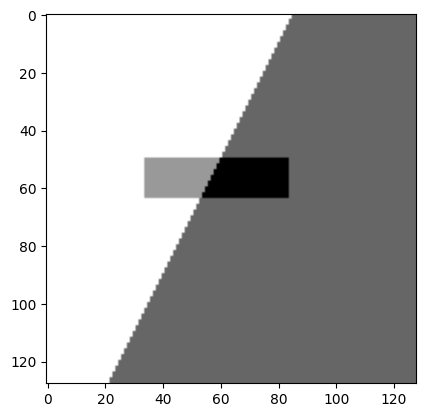

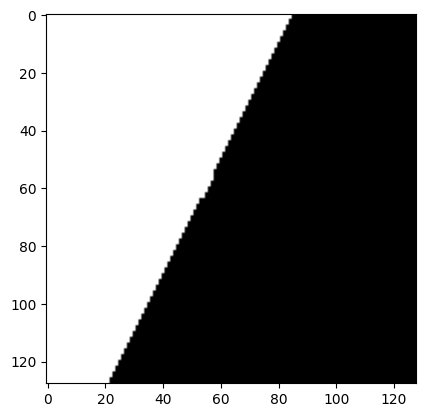

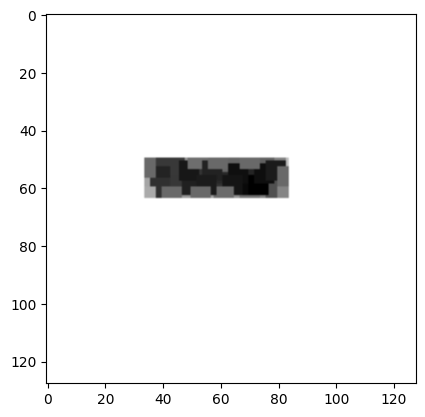

255.0 0.0


In [413]:
image = 255 * np.ones((128, 128), dtype=int)
for i in range(mask.shape[0]):
    for j in range(mask.shape[1]):
        if (i + 2 * j >= 170):
            image[i, j] = 0

mask = np.ones((128, 128), dtype=bool)
mask[50:64, 34:84] = False
mask_with_boundary = MaskWithBoundary(mask)

overlay_mask_image(mask_with_boundary, image, alpha=0.4)

objrem = ObjectRemove(PATCH_SIZE, image)
objrem.fill_region(mask_with_boundary)